- Import a single stock
- Calculate Moving Average
- Calculate STD
- Check if any day's close price is more than 2 STD's lower than the MA
- If yes, mark it on a graph
- Check if it recovers from the fall


## TODOs

- Put all tickers together
- Make call for last 5 min data

In [10]:
import os
from os.path import exists
from glob import glob
import shutil
import time
from IPython.display import clear_output

import yfinance as yf

import pandas as pd
import numpy as np
from numpy import NaN

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from playsound import playsound

import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')

my_year_month_fmt = mdates.DateFormatter('%m/%y')


In [74]:
def delete_data_dir():
    for match in glob('*data'):
       shutil.rmtree(match)

delete_data_dir()

In [35]:
# large_cap = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].values.tolist()[:5]
# mid_cap = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_400_companies')[0]['Ticker symbol'].values.tolist()[:5]
# small_cap = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_600_companies')[1]['Ticker symbol'].values.tolist()[:5]

In [72]:

# https://www.investopedia.com/top-energy-stocks-4582081
energy_most_momentum = ['AR', 'OXY', 'DVN', 'XLE']
energy_fast_growing = ['MRO', 'CTRA', 'COP']
energy_low_pe_0827 = ['APA', 'MRC', 'FANG']

# https://finance.yahoo.com/news/10-energy-stocks-buy-winter-230454016.html
yahoo_energy_picks = ['XOM', 'CVX', 'DVN', 'TTE', 'ENB', 'BP', 'CTRA', 'VLO', 'BP']

energy_tickers = list(set(
    yahoo_energy_picks + 
    energy_low_pe_0827 + 
    energy_fast_growing + 
    energy_most_momentum +
    ['RYDAF', 'EQNR', 'PTR', 'PBR']
))


alt_energy_eu = ['VWDRY', 'DNNGY', 'IBDRY']
# https://www.investopedia.com/investing/alternative-energy-stocks/ ++
alt_energy_others = ['JKS', 'TAC', 'DQ', 'CWEN', 'EE', 'AQN', 'ENPH', 'EVA', 'ORA', 'ICLN', 'NEE', 'BEP', 'BEPC', 'FSLR', 'SEDG', 'RUN', 'NOVA']
# https://seekingalpha.com/news/3841098-solar-clean-energy-stocks-surge-again-on-europes-planned-green-push
alt_energy_seeking_alpha = ['TAN', 'ENPH' 'SEDG', 'SHLS', 'MAXN', 'FTCI', 'SPWR', 'SOL', 'CSIQ', 'ARRY', 'JKS', 'NOVA', 'RUN', 'DQ', 'FSLR', 'BE', 'BLDP', 'GNRC', 'FCEL', 'PLUG', 'FAN', 'ICLN', 'QCLN', 'PBW', 'PBD', 'ACES', 'CNRG', 'SMOG', 'ERTH']


alt_energy_tickers = list(set(
    alt_energy_eu +
    alt_energy_others +
    alt_energy_seeking_alpha
))

# tickers = large_cap + mid_cap + small_cap
# tickers = sorted(energy_tickers)
tickers = sorted(alt_energy_tickers[:15])

tickers, len(tickers)

(['ACES',
  'AQN',
  'BE',
  'BEP',
  'BLDP',
  'CSIQ',
  'CWEN',
  'DNNGY',
  'EE',
  'ENPH',
  'FCEL',
  'FSLR',
  'PBW',
  'PLUG',
  'TAN'],
 15)

In [73]:
today = time.strftime("%Y-%m-%d")
data_path_today = f'{today}_data'
period = '6mo'
ma_and_std_window = 20

In [75]:
def download_data(tickers):
    return yf.download(
      tickers = tickers, # 'SPDR S&P 500 ETF Trust'
      period=period,
      interval='1d',
      group_by = 'ticker'
  )


In [76]:
def use_existing_data(data_path_today, tickers):
    multi_df = {}
    
    for ticker in tickers:
        filepath = f"{data_path_today}/{today}_{ticker}"
        if exists(filepath):
            df = pd.read_csv(filepath, index_col=['Date'], parse_dates=['Date'])
            multi_df[ticker] = df

    return multi_df

    
def get_and_prep_new_stock_data(multi_df, tickers, data_path_today, today):
  new_multi_df = {}

  for ticker in tickers:
    df = multi_df[ticker][['Close']]
    df['Close Rolling Mean'] = df.Close.rolling(ma_and_std_window).mean()
    df['Close STD'] = df.Close.rolling(ma_and_std_window).std()

    df['1 STD Below Mean (Val)'] = df['Close Rolling Mean'] - df['Close STD']
    df['1 STD Below Mean (Bool)'] = df['Close'] < df['1 STD Below Mean (Val)']
    
    df['2 STD Below Mean'] = df['Close Rolling Mean'] - 2 * df['Close STD']
    df['2 STD Below Mean (Close)'] = np.where(df['Close'] < df['2 STD Below Mean'], df['Close'], NaN)
    
    # Count how many stocks have this condition
    
    df.to_csv(f"{data_path_today}/{today}_{ticker}")

    new_multi_df[ticker] = df

  return new_multi_df

multi_df = {}

if exists(data_path_today):
    print("Reusing data")
    multi_df = use_existing_data(data_path_today, tickers)
else:
    print("Getting new data")
    os.mkdir(data_path_today)
    multi_df = download_data(tickers)
    multi_df = get_and_prep_new_stock_data(multi_df, tickers, data_path_today, today)

Getting new data
[*********************100%***********************]  15 of 15 completed


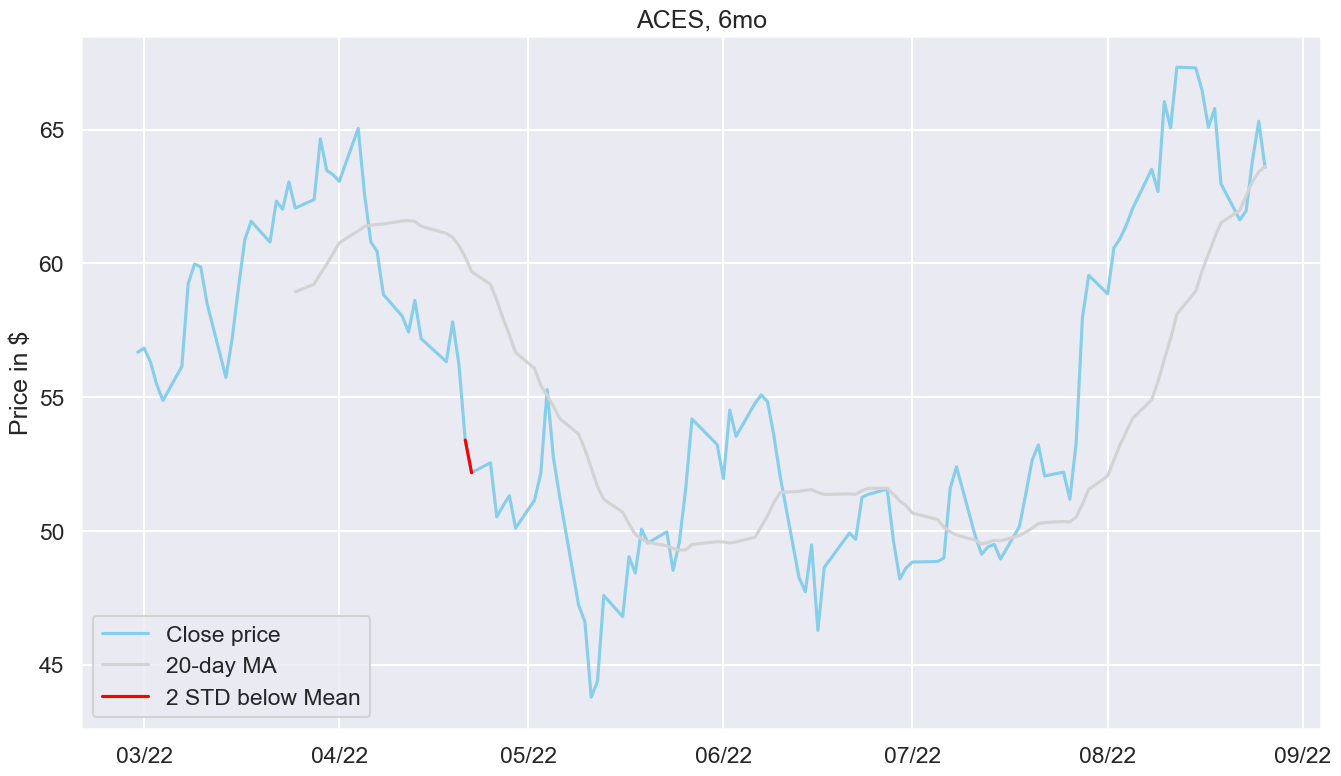

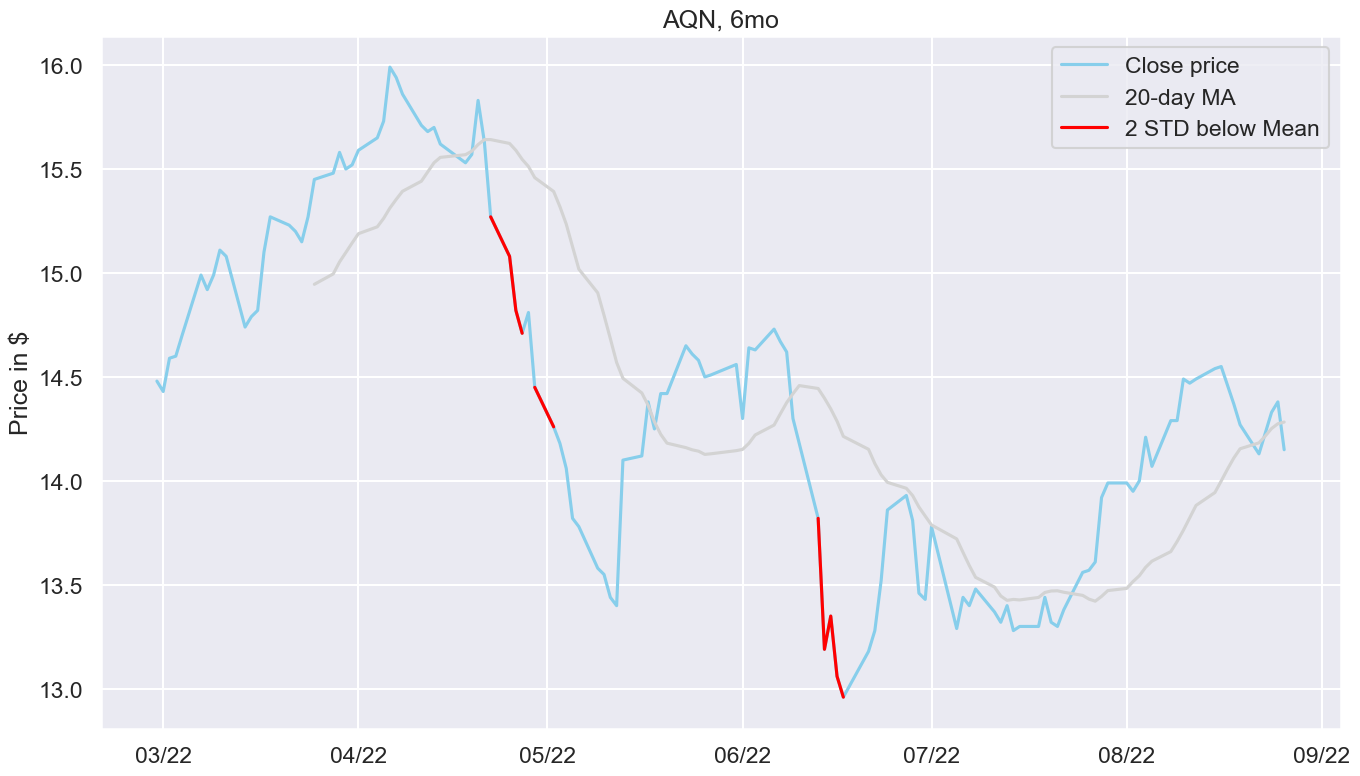

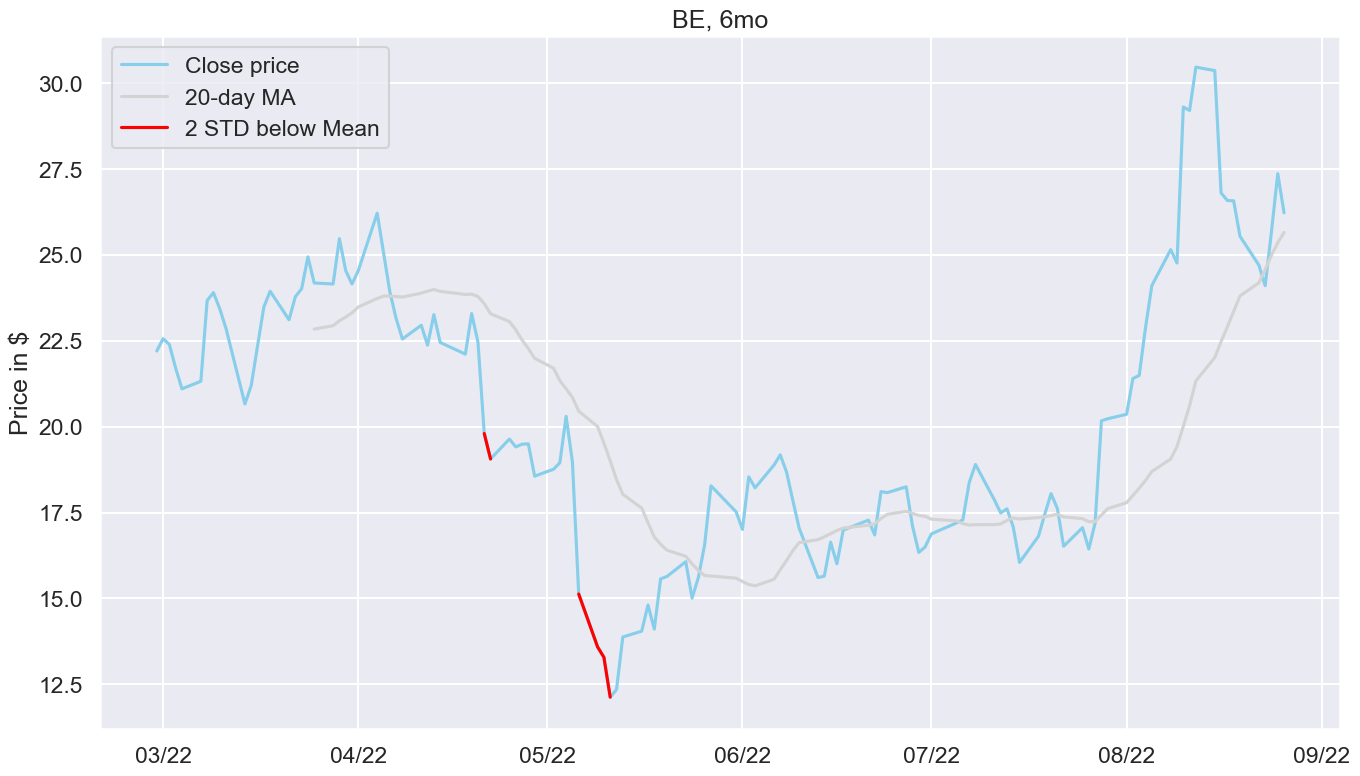

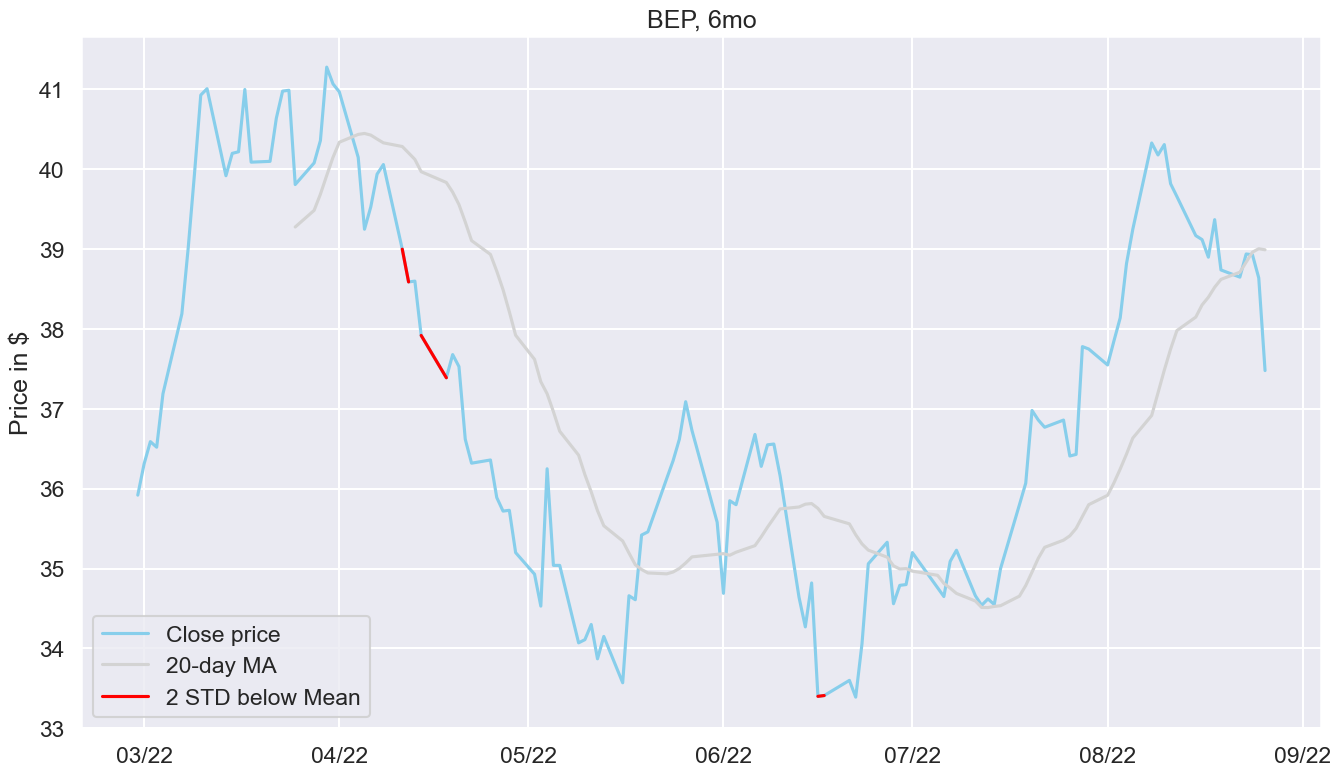

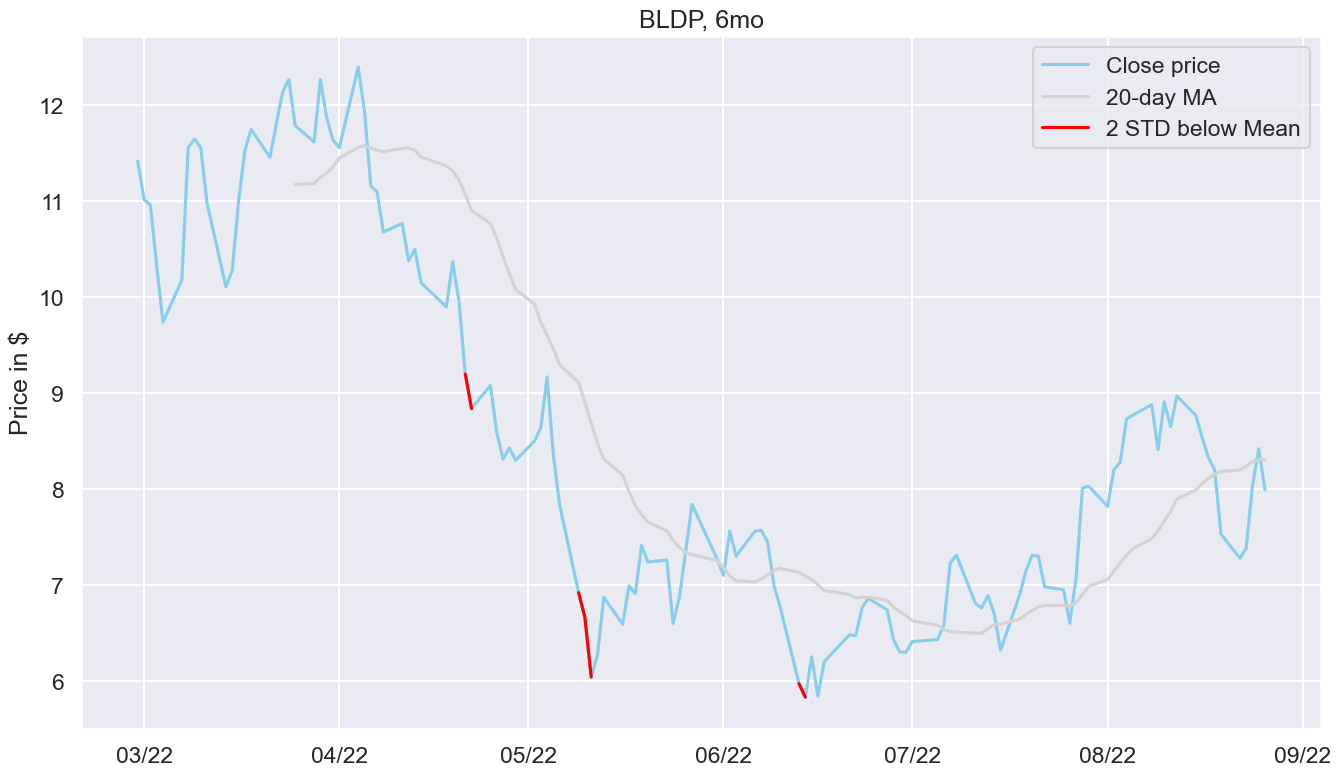

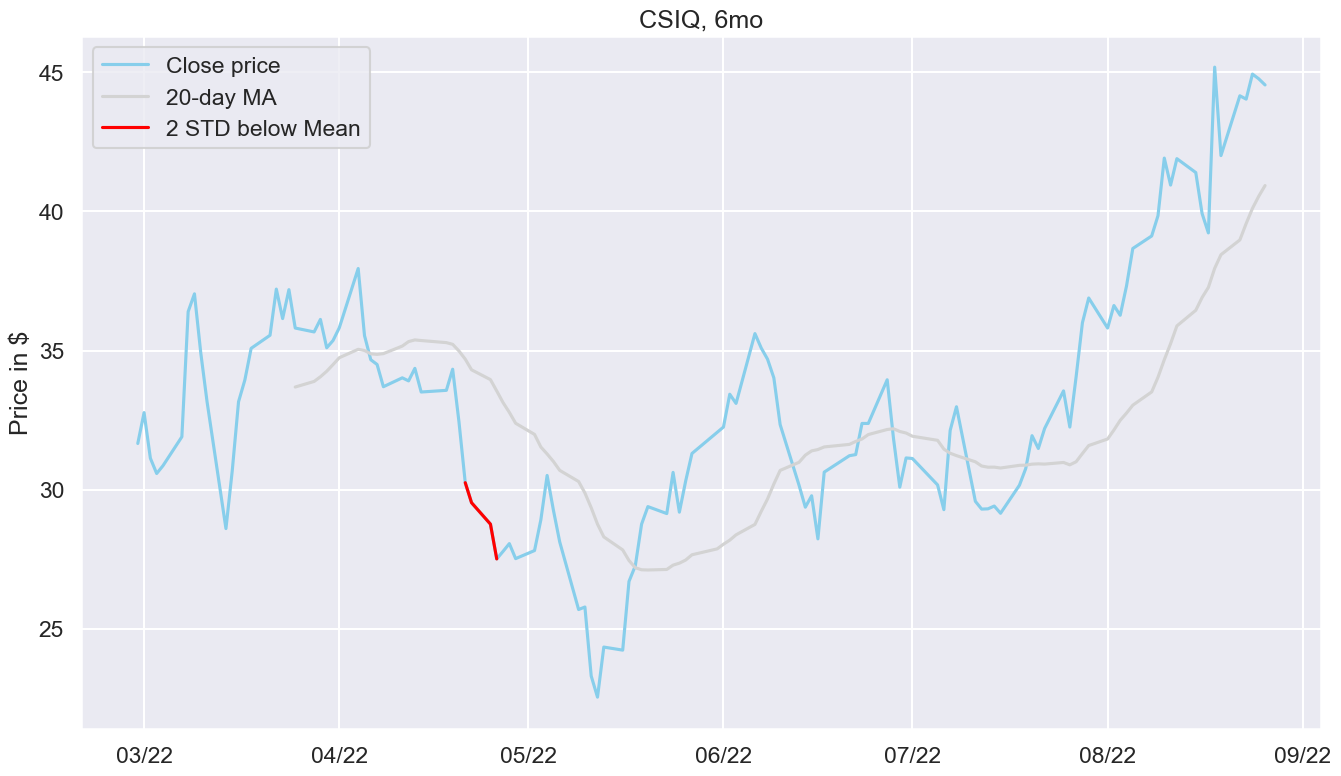

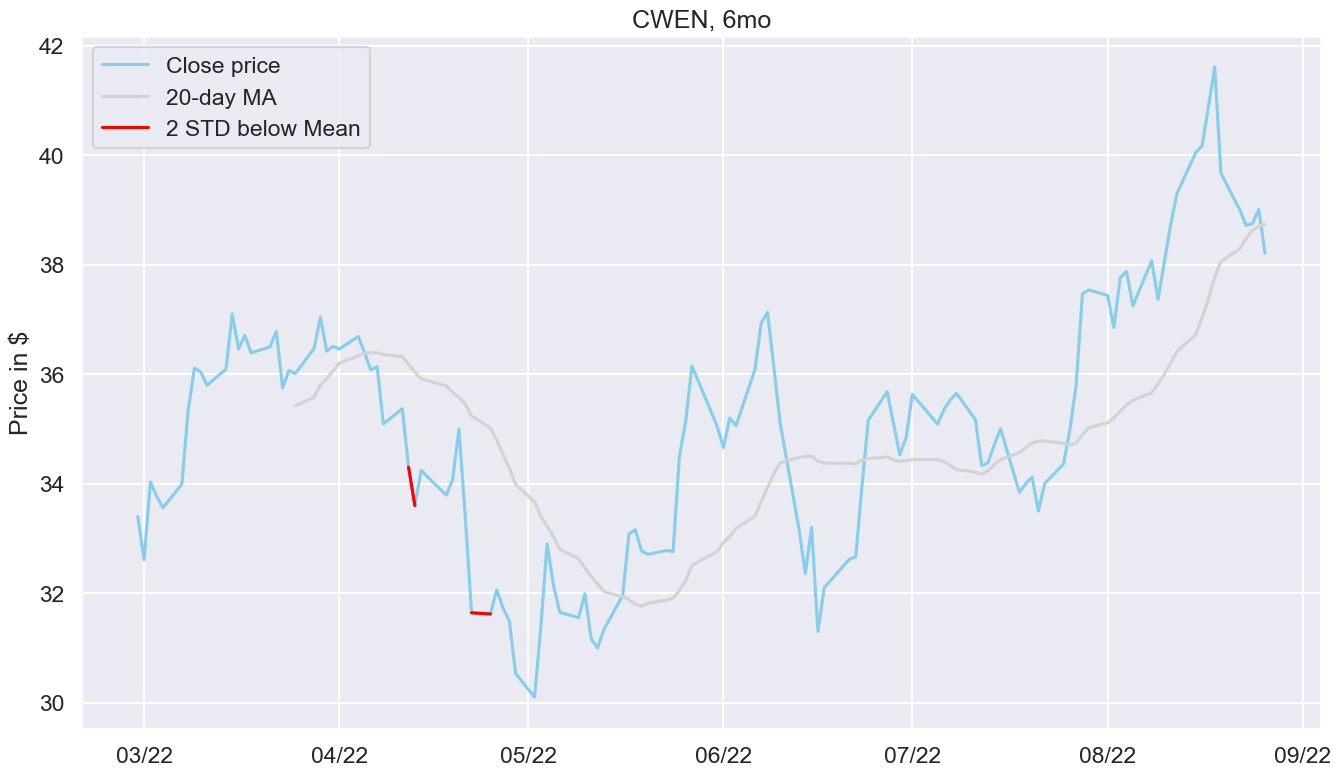

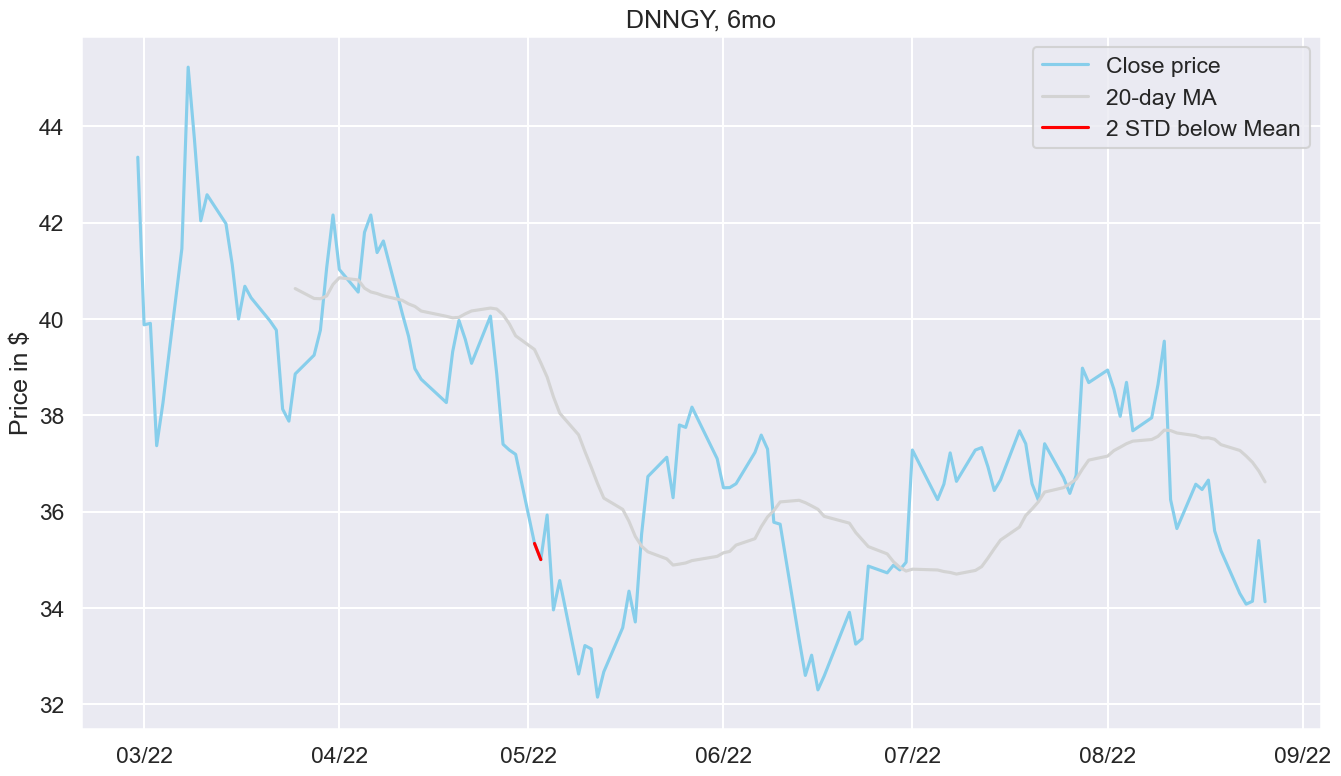

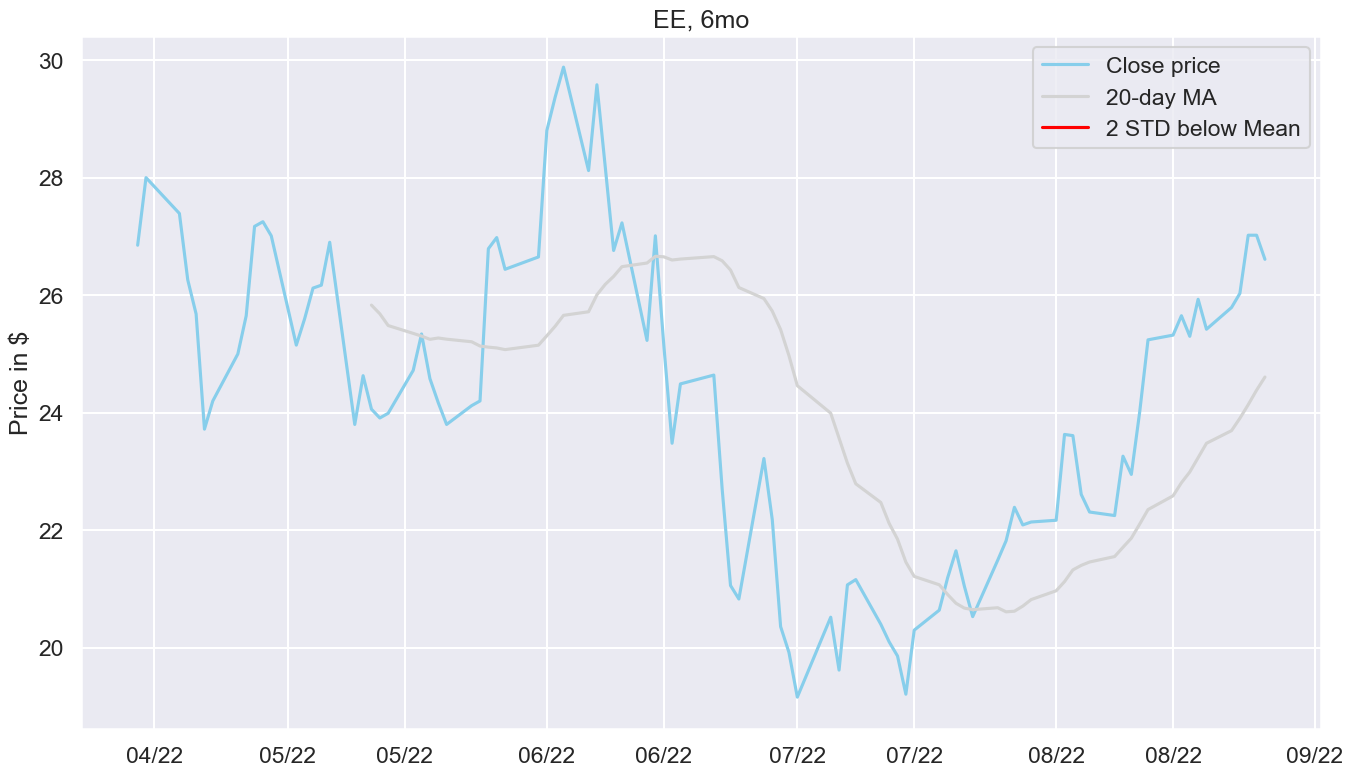

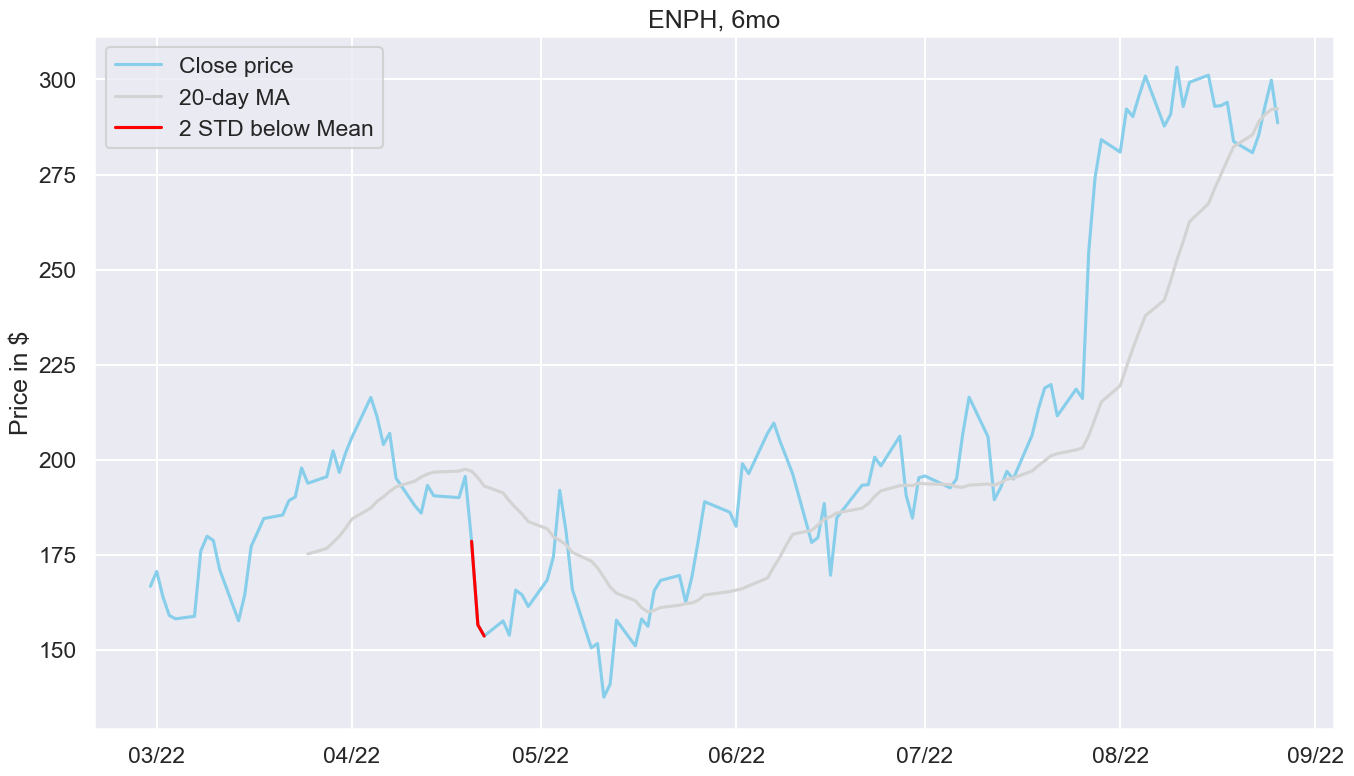

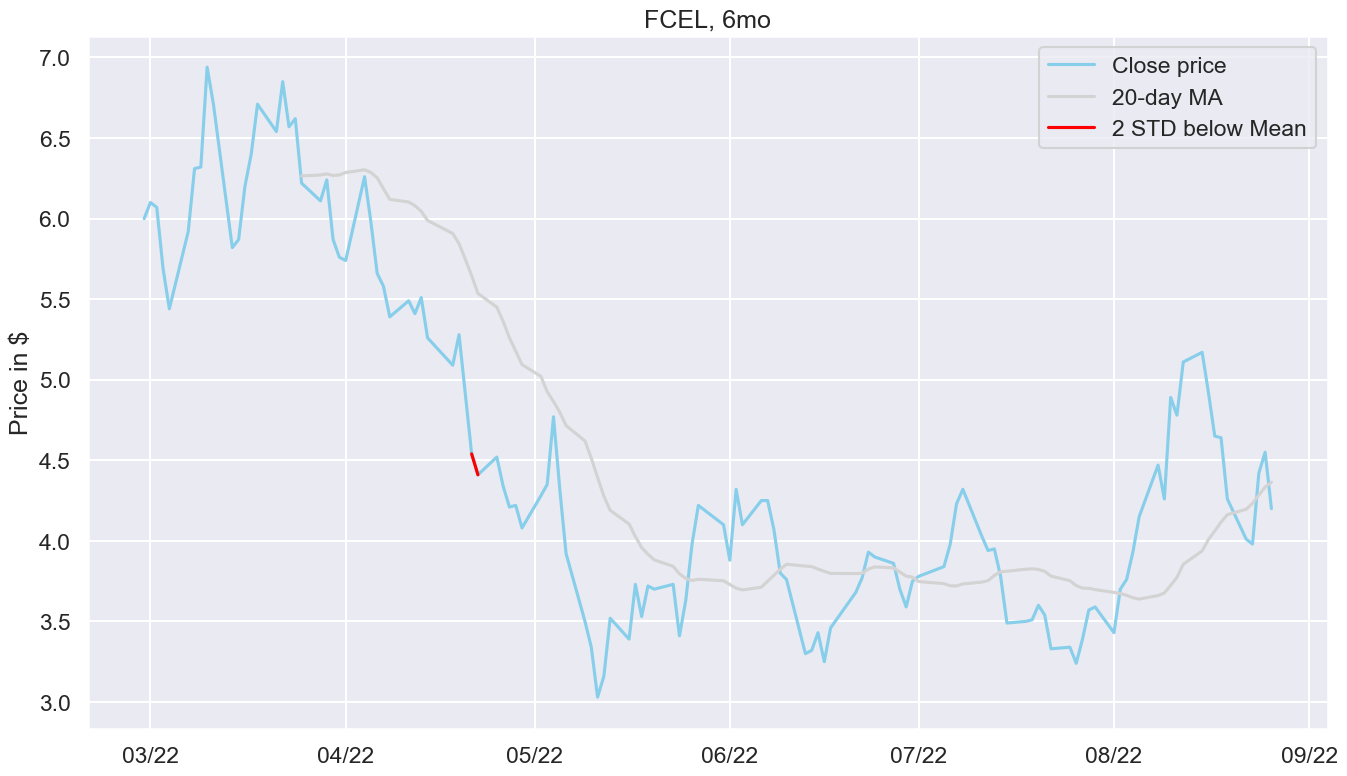

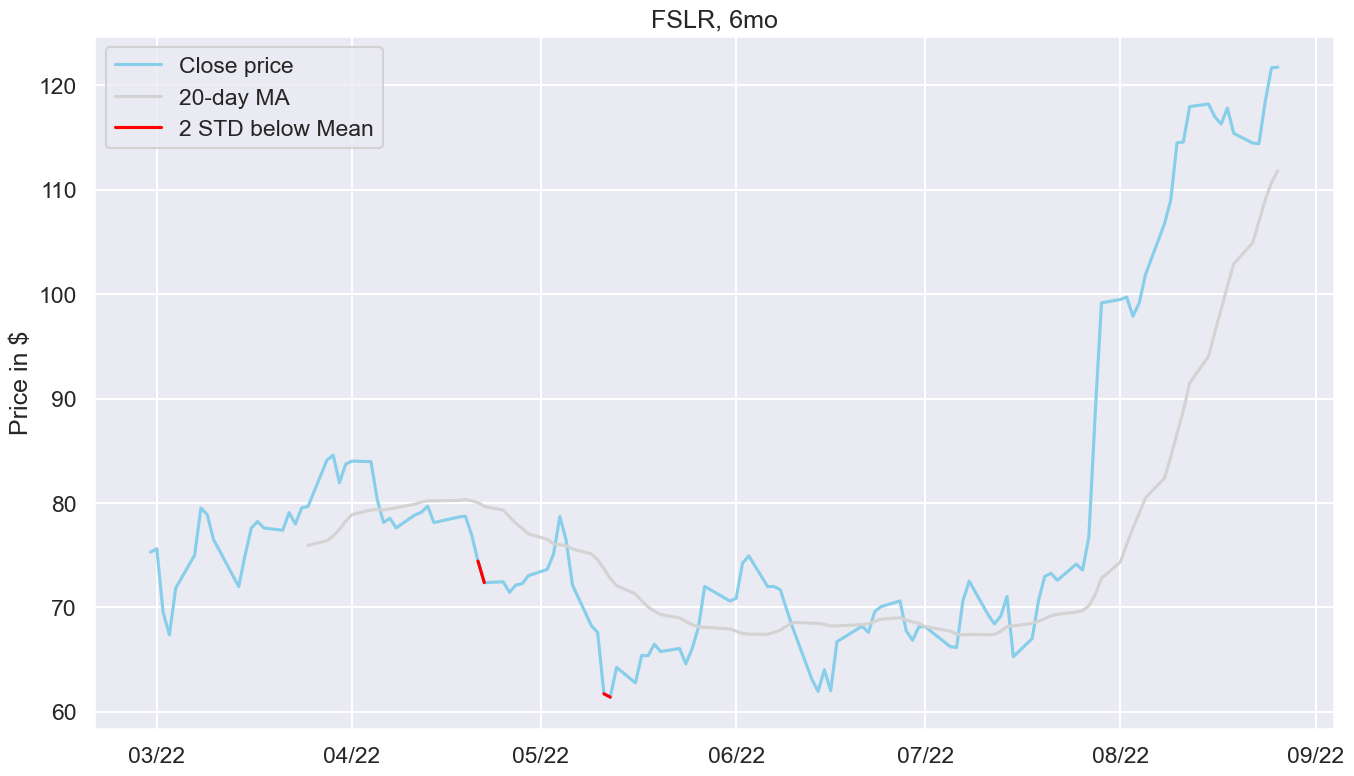

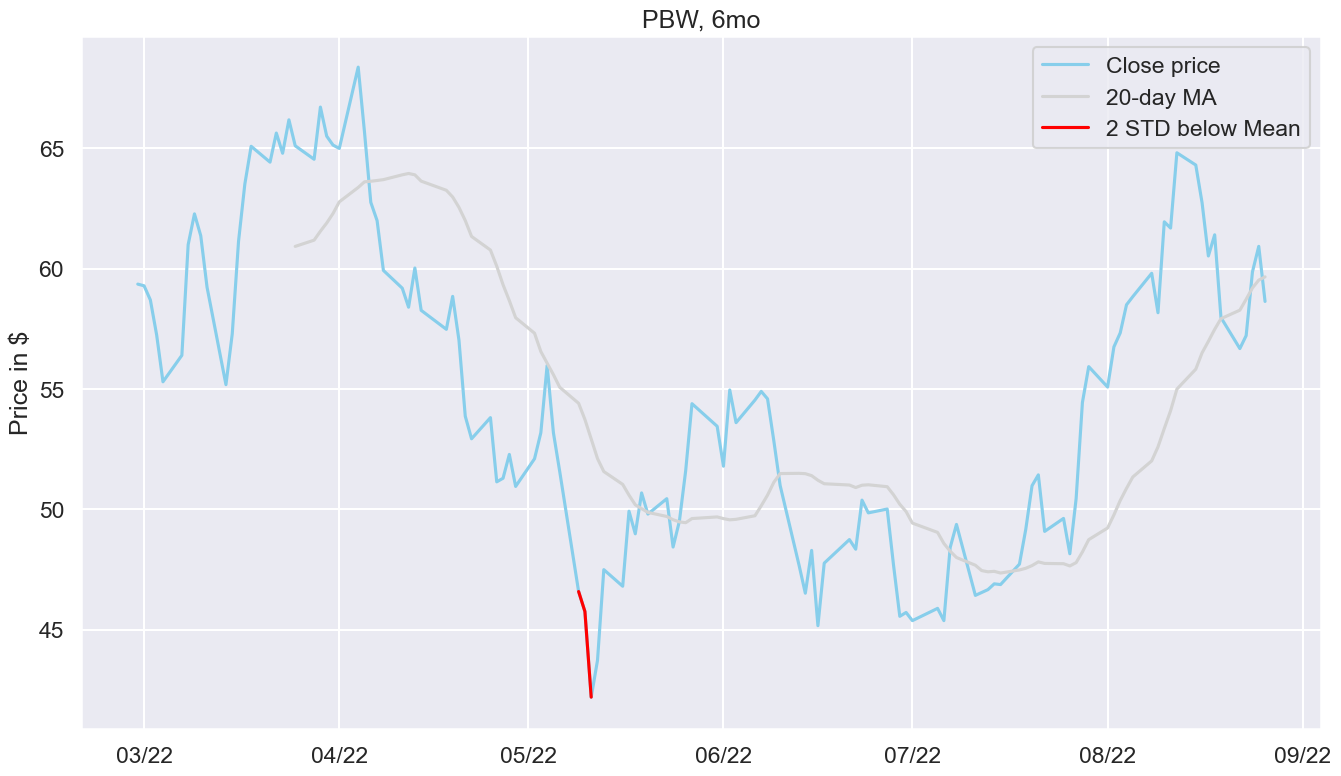

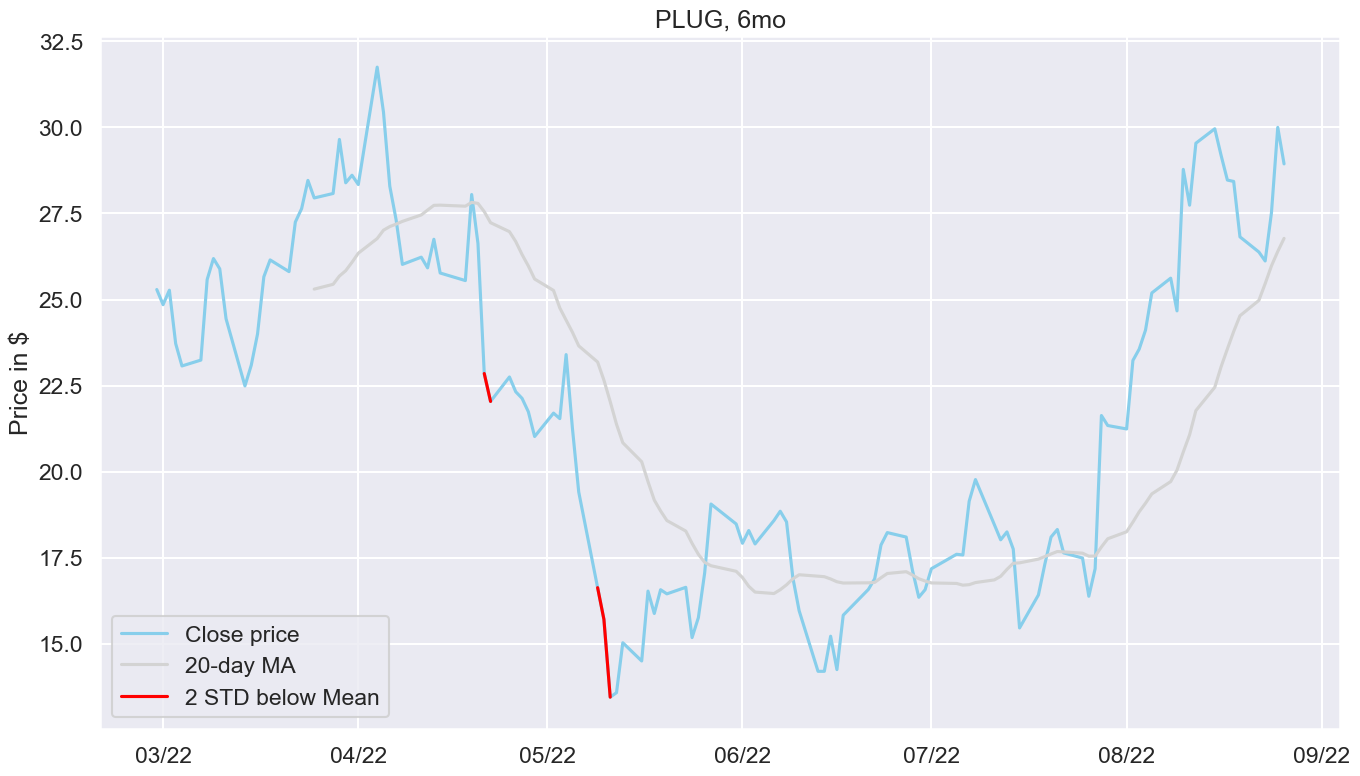

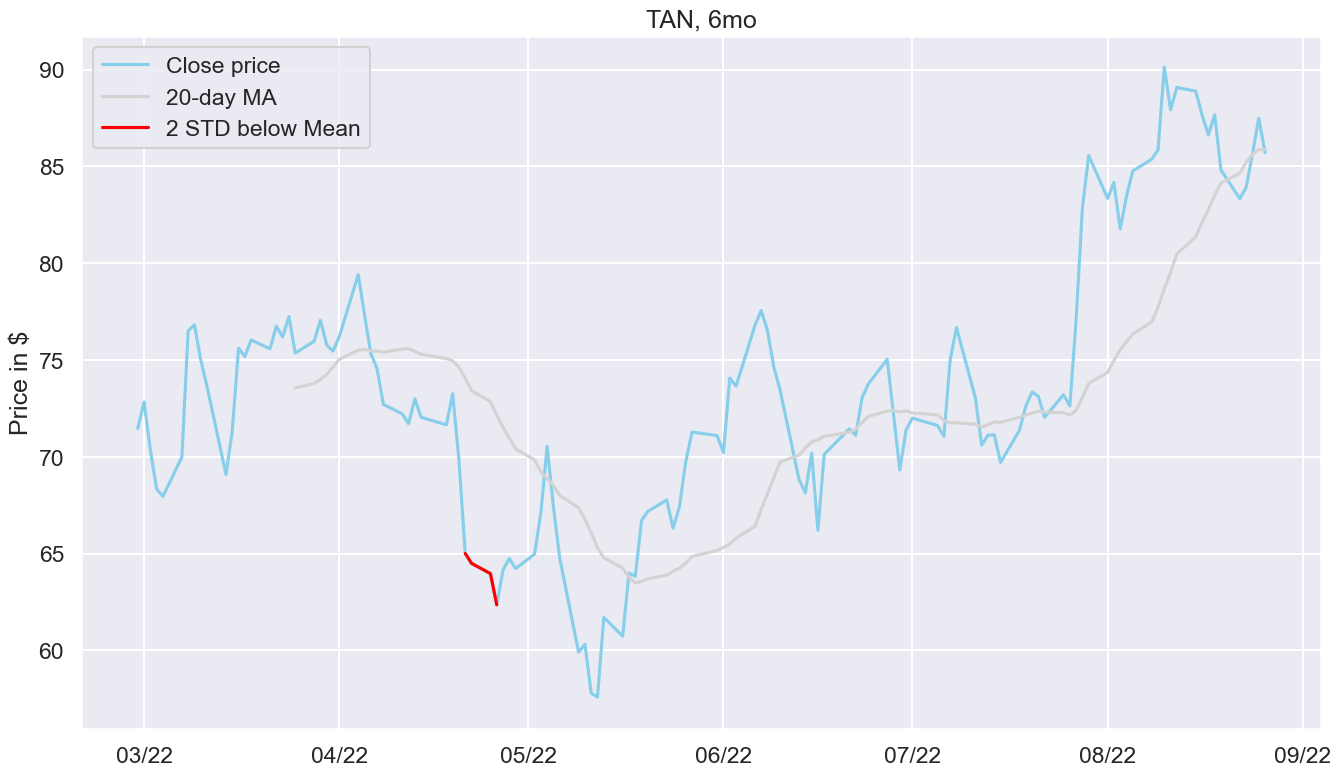

In [82]:
def plot_tickers(tickers):
    for ticker in tickers:
        df = multi_df[ticker]
        fig, ax = plt.subplots(figsize=(16,9))

        ax.plot(df.index, df.Close, label='Close price', color='skyblue')
        ax.plot(df.index, df['Close Rolling Mean'], label = f'{ma_and_std_window}-day MA', color='lightgrey')
        ax.plot(df.index, df['2 STD Below Mean (Close)'], label = f'2 STD below Mean', color='red')

        ax.legend(loc='best')
        ax.set_ylabel('Price in $')
        ax.set_title(f'{ticker}, {period}')
        ax.xaxis.set_major_formatter(my_year_month_fmt)

plot_tickers(tickers)

In [78]:
# min = 900 # 15 min
min = 3

def keep_running(multi_df, tickers, min):
    
    while True:
        clear_output(wait=False)
        
        watchlist = []
        
        # Get last 5 min's average close price        
        mock_close = 50
        
        for ticker in tickers:
            df = multi_df[ticker]
            two_std_below_mean = df.iloc[len(df)-2]['2 STD Below Mean']
            
            if mock_close < two_std_below_mean:
                
                watchlist.append({
                    "ticker": ticker,
                    "close": mock_close
                })
                
                playsound('sound.mp3')
        
        for item in watchlist:
            print(f"{item['ticker']}: {item['close']}")

        time.sleep(min)

keep_running(multi_df, tickers, min)

SyntaxError: f-string: expecting '}' (1536303679.py, line 28)